# Face Identification

Output vector: **16** x float32  
Dataset size: **20** / 2194  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth
/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth
/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-11ad3fa6.pth
/kaggle/input/faceid-preprocessed-small/youtube_faces_with_keypoints_full.csv
29


In [2]:
!df /kaggle/

Filesystem     1K-blocks     Used Available Use% Mounted on
/dev/vda1      162420480 21344580 141059516  14% /


In [3]:
#!mkdir -pv /kaggle/temp
#!rm -Rf /kaggle/temp/*
#!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
#!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
#!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

In [4]:
#data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
data_dir = '/kaggle/input/faceid-preprocessed-small'

In [5]:
# Updating to the recent pretrained data
!rm -Rf ~/.cache/torch/hub/checkpoints/
!mkdir -pv ~/.cache/torch/hub/checkpoints/
!cp -avs /kaggle/input/torchvision-resnet-pretrained/resnet*.pth ~/.cache/torch/hub/checkpoints/
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth ~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth ~/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth ~/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
!ls -l ~/.cache/torch/hub/checkpoints/

mkdir: created directory '/home/ubuntu/.cache/torch'
mkdir: created directory '/home/ubuntu/.cache/torch/hub'
mkdir: created directory '/home/ubuntu/.cache/torch/hub/checkpoints/'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth' -> '/home/ubuntu/.cache/torch/hub/checkpoints/resnet34-b627

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
5,Alison_Lohman_5,Alison_Lohman,227.0,179.0,68.0,105.647059,6.0
6,Kevin_Spacey_0,Kevin_Spacey,196.0,264.0,91.0,99.912088,6.0
7,Kevin_Spacey_1,Kevin_Spacey,260.0,217.0,59.0,120.186441,6.0
8,Kevin_Spacey_2,Kevin_Spacey,186.0,175.0,71.0,86.746479,6.0
9,Kevin_Spacey_3,Kevin_Spacey,100.0,89.0,99.0,44.636364,6.0


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchinfo import summary

In [9]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [10]:
import random
import pickle

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        need_preprocessing = []
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    need_preprocessing += [fp]
        if preprocess:
            preprocessed = [self._preprocess(fp) for fp in tqdm(need_preprocessing, desc='Preprocessing')]
            self.preprocessed_cache = dict((fp, self._load_preprocessed(pfp)) for fp, pfp in tqdm(preprocessed, desc='Loading data'))
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return (fp, pfp)
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir)
len(dataset)

Loading data: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 569.41it/s]


4

In [11]:
to_pil_transform = torchvision.transforms.ToPILImage()
#to_pil_transform(dataset[0][1])

In [12]:
def dev_list():
    return [torch.cuda.get_device_properties(torch.device(f'cuda:{i}')) for i in range(torch.cuda.device_count())]

def train_triplet_multigpu(model, dataset, num_epochs,
                           lr = 0.001, batch_size = 16,
                           target_loss = 0, lr_reduct_loss_threshold = 0.02):
    model.train()
    model = nn.DataParallel(model)
    model.to(torch.device('cuda'))
    
    loss = nn.TripletMarginLoss()
    loss_history = []
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f'lr: {lr}')
    for epoch in range(1, num_epochs+1):
        loss_accum = 0
        loss_cnt = 0
        for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
            ya = model(xa)
            yp = model(xp)
            yn = model(xn)
            loss_data = loss(ya, yp, yn)
            
            optimizer.zero_grad()
            loss_data.backward()
            optimizer.step()
            
            loss_accum += float(loss_data)
            loss_cnt += 1

        loss_value = loss_accum / loss_cnt
        print(f'loss: {loss_value}')

        if loss_history and loss_value > loss_history[-1] * (1 - lr_reduct_loss_threshold):
            lr *= 0.1
            print(f'lr: {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
        
        loss_history.append(loss_value)
        
        if loss_value <= target_loss:
            print(f'target loss {target_loss} reached')
            break

    return loss_history

In [13]:
def create_faceid_model():
    model = torchvision.models.resnet50(weights='DEFAULT')
    model.fc = nn.Linear(model.fc.in_features, 16)
    return model

def grayscale_fix_model(model):
    w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1.weight.data = w
    return model

def set_trainable(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

In [14]:
dataset = YouTubeFacesDataset(df, data_dir, anchor_set_len=10, positive_set_len=10, negative_set_len=10, preprocess=True)
len(dataset)

Loading data: 100%|████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.19it/s]


4000

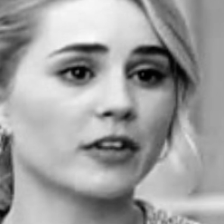

In [15]:
to_pil_transform(dataset[0][1])

In [16]:
dev_list()

[_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68),
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68),
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68),
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)]

lr: 0.001


train 1/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


loss: 0.864323303103447


train 2/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


loss: 0.44169936515390873


train 3/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


loss: 0.20860141003504395


train 4/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


loss: 0.10273106000386178


train 5/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


loss: 0.070088971988298


train 6/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


loss: 0.05925361311528832


train 7/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


loss: 0.041954763990361243


train 8/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


loss: 0.03348069766070694


train 9/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


loss: 0.027517473477928434


train 10/10: 100%|█████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]

loss: 0.02707103404100053
lr: 0.0001


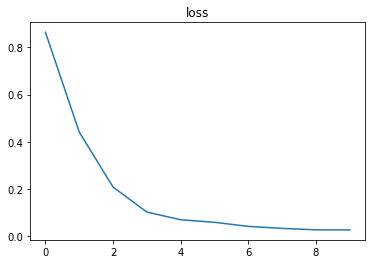

In [17]:
loss_history = train_triplet_multigpu(model, dataset, 10, batch_size=256)
plt.plot(loss_history)
plt.title('loss');

In [18]:
model.to(torch.device('cpu'));

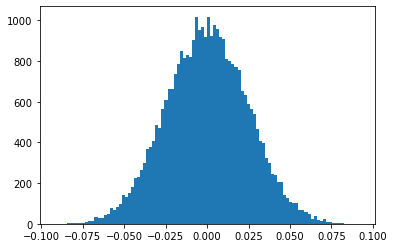

In [19]:
plt.hist(model.fc.weight.detach().reshape(-1).numpy(), bins=100);

In [20]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [21]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

0.55962884 1.7660952 0.9145623 -0.03849246 -0.5076527 0.59539914
0.53014386 0.9515629 0.8772537 0.6021704 -0.53353375 0.581999
0.31290182 1.6428106 0.9538409 -0.1646257 -0.44217315 0.4797867
0.39003235 0.7207973 0.89743453 0.6304893 -0.34510982 0.44407678
0.50497496 1.1618744 0.8509293 0.2135544 -0.44237426 0.50011915
0.6528139 1.1695907 0.8349631 0.25186682 -0.48014808 0.5225099
0.510555 0.98304605 0.842162 0.40840513 -0.3529473 0.4502244
0.50901526 0.8760943 0.89711046 0.6973037 -0.46626425 0.58455455
0.7323909 1.0850252 0.8336621 0.5822074 -0.48591924 0.5833386
0.4719661 1.3892995 0.9443785 0.071777456 -0.36605766 0.5445261


In [22]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')

In [23]:
dataset = YouTubeFacesDataset(df, data_dir, anchor_set_len=5, positive_set_len=5, negative_set_len=5, preprocess=True)
len(dataset)

Loading data: 100%|████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.98it/s]


500

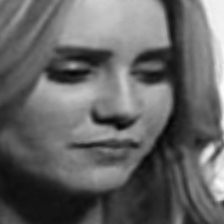

In [24]:
to_pil_transform(dataset[0][1])

lr: 1e-05


train 1/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


loss: 0.09596354374662042


train 2/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


loss: 0.0674211629666388


train 3/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


loss: 0.07221439643763006
lr: 1.0000000000000002e-06


train 4/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s]


loss: 0.050476317992433906


train 5/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


loss: 0.05109632504172623
lr: 1.0000000000000002e-07


train 6/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.96it/s]


loss: 0.05084608250763267
lr: 1.0000000000000004e-08


train 7/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


loss: 0.03140991856344044


train 8/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.05it/s]


loss: 0.045448237331584096
lr: 1.0000000000000005e-09


train 9/10: 100%|██████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.04it/s]


loss: 0.0701765117701143
lr: 1.0000000000000006e-10


train 10/10: 100%|█████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]

loss: 0.030934562208130956


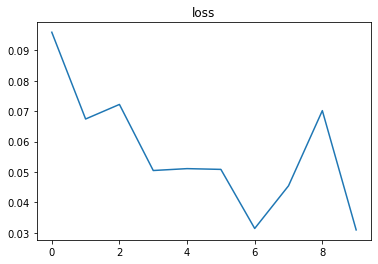

In [25]:
model.requires_grad_(True)
loss_history = train_triplet_multigpu(model, dataset, 10, target_loss=0.01, lr=0.00001, batch_size=32)
plt.plot(loss_history)
plt.title('loss');

In [26]:
model.to(torch.device('cpu'));

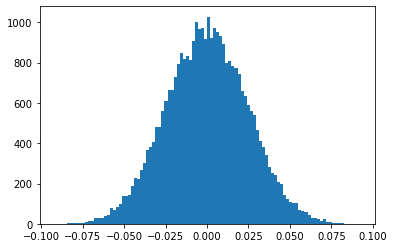

In [27]:
plt.hist(model.fc.weight.detach().reshape(-1).numpy(), bins=100);

In [28]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

0.50474346 0.56184274 0.92504096 0.90669113 -0.36185533 0.54223996
0.42450494 0.7707909 0.9008988 0.65468806 -0.3857577 0.47424057
0.47938517 1.416911 0.9215252 0.108782105 -0.49119145 0.5290019
0.41992462 2.2588415 0.9891324 -0.13878225 -0.547328 0.67659855
0.3131103 1.535563 0.9782804 0.18007614 -0.52466154 0.62051237
0.3883414 0.9491012 0.94805217 0.53583986 -0.42004383 0.4529255
0.51933515 0.99856555 0.8679734 0.26553446 -0.3633734 0.48897135
0.37139115 1.2947111 0.95792234 0.27389655 -0.49521008 0.5609256
0.8037215 0.9511264 0.8451237 0.2639654 -0.43794677 0.59579736
0.31931108 1.5110506 0.9588267 0.0680005 -0.4685781 0.5419498


In [29]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')
!ls -l faceid-model-*.pt

-rw-rw-r-- 1 ubuntu ubuntu 94470465 Sep 28 09:26 faceid-model-0.02707103404100053.pt
-rw-rw-r-- 1 ubuntu ubuntu 94470465 Sep 28 09:27 faceid-model-0.030934562208130956.pt
